In [5]:
import gc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import seaborn as sns

In [25]:
jtplot.style()

# Chapter 0a Data to feather
- 這邊可以善用feather format, 可以大幅的提高資料後續載入速度
- https://www.kaggle.com/corochann/ashrae-feather-format-for-fast-loading
- https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d

In [6]:
%%time
train_df    = pd.read_csv('ASHRAE_dataset/train.csv')
test_df     = pd.read_csv('ASHRAE_dataset/test.csv')
building_df = pd.read_csv('ASHRAE_dataset/building_metadata.csv')
weather_train_df  = pd.read_csv('ASHRAE_dataset/weather_train.csv')
weather_test_df = pd.read_csv('ASHRAE_dataset/weather_test.csv')

Wall time: 17.4 s


- 先將Object編碼，這邊會使用label encoder的原因是LightGBM本身就有Categorical的分類

In [3]:
le = LabelEncoder()
building_df.primary_use = le.fit_transform(building_df.primary_use)

In [ ]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

In [ ]:
train_df.to_feather('ASHRAE_dataset/train.feather')
test_df.to_feather('ASHRAE_dataset/test.feather') 
weather_train_df.to_feather('ASHRAE_dataset/weather_train.feather')
weather_test_df.to_feather('ASHRAE_dataset/weather_test.feather')
building_df.to_feather('ASHRAE_dataset/building.feather')

In [ ]:
del train_df,test_df,building_df,weather_train_df,weather_test_df
gc.collect()

# Chapter 0b 後續讀取Feather(Speed Up!)

In [1]:
%%time
train_df = pd.read_feather('ASHRAE_dataset/train.feather')
weather_train_df = pd.read_feather('ASHRAE_dataset/weather_train.feather')
test_df = pd.read_feather('ASHRAE_dataset/test.feather')
weather_test_df = pd.read_feather('ASHRAE_dataset/weather_test.feather')
building_df = pd.read_feather('ASHRAE_dataset/building.feather')

Wall time: 4.45 s


### Function to reduce the DF size
### Useful methods that coverting the data format to proper size
- 用剛好的數值格式存取就可以了，不然記憶體非常容易爆掉
- 善用del和gc.collect()

In [2]:
## Memory optimization
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
train_df = reduce_mem_usage(train_df,use_float16=True)
weather_train_df = reduce_mem_usage(weather_train_df,use_float16=True)
building_df = reduce_mem_usage(building_df,use_float16=True)
test_df = reduce_mem_usage(test_df,use_float16=False)
weather_test_df = reduce_mem_usage(weather_test_df,use_float16=False)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 289.19 MB
Decreased by 53.1%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 3.07 MB
Decreased by 68.1%
Memory usage of dataframe is 0.06 MB
Memory usage after optimization is: 0.02 MB
Decreased by 72.6%
Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 596.49 MB
Decreased by 53.1%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 9.78 MB
Decreased by 48.6%


# Chapter 1 EDA 資料探勘
### 目的: 了解如何去除異常值 / 如何做特徵工程

## 數值意義
- train.csv:
    - building_id: FK
    - meter: 四種type {0: electricity, 1: chilledwater, 2: steam, hotwater: 3}
    - timestamp
    - meter_reading: 數值數據
    - 目標：kwh power comsumption
- building_meta.csv:
    - site_id: FK 對應weather
    - building_id: FK 對應training
    - primary_use: 主要使用用途
    - square_feet: 建築有多大
    - year_built: 建築蓋的時間
    - floor_count: 建築有幾層樓
- weather
    - site_id: FK
    - air_temperture: 溫度
    - cloud_coverage: 烏雲覆蓋率
    - dew_temperature: 露點溫度: 代表空氣中所有氣態水凝固的溫度，露點溫度越高，濕度越高
    - precip_depth_1_hr: 平均降雨深度(注意 有些會被編碼成-1)
    - sea_level_pressure: 海平面氣壓
    - wind_direction:風向
    - wind_speed: 風速
    

- Missing Value by EDA
- https://github.com/ResidentMario/missingno

In [14]:
temp = train_df.merge(building_df, on='building_id', how='left')
temp = temp.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')

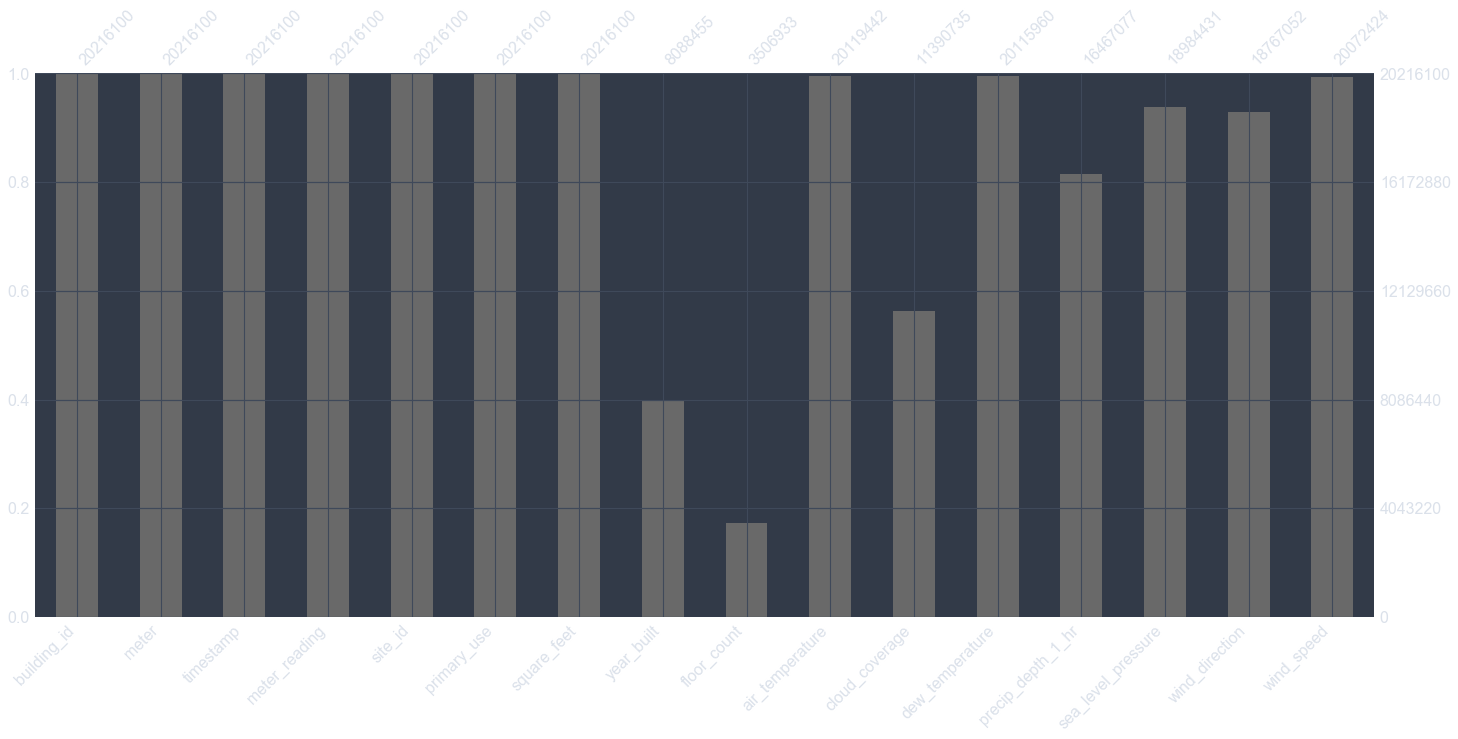

In [18]:
msno.bar(temp)

- We can see, floor_count and year_bulit counts are below 50%, so we need to handle with NaN value later

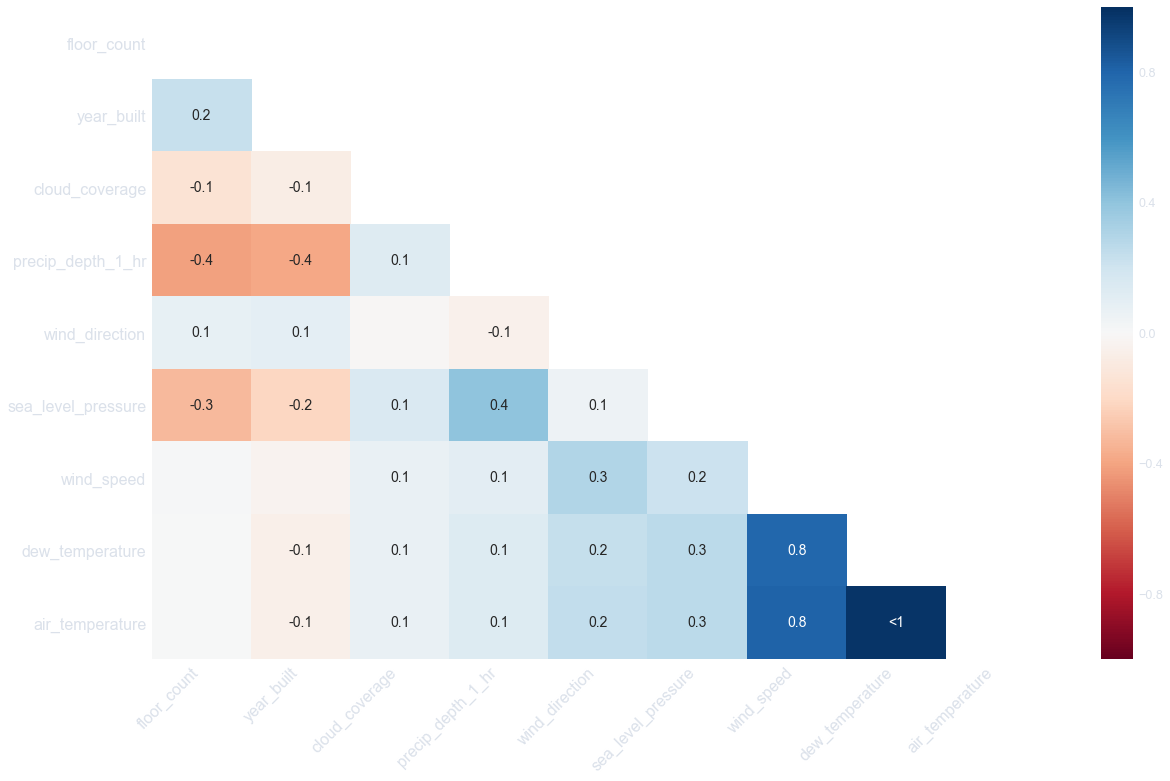

In [21]:
msno.heatmap(temp, sort='ascending')
# Exploring about the correaltion with different value

## 檢視耗能與時間的變化
- 目的：初步了解資料分布的情況，和時間的相關性

- {0: electricity, 1: chilledwater, 2: steam, hotwater: 3}  
  在這邊有四種電錶，分別是不同種類的電力耗能  
  將數據用resample檢視每天的變化，以median去除極端值，基本上，電力耗能均為差不多，而Steam在冬季最為耗能，冷卻水在夏季最為耗能  
  符合一般常理季節現象，也代表後續timestamp一定要做時間編碼  

In [32]:
train_df.index = pd.to_datetime(train_df.timestamp)


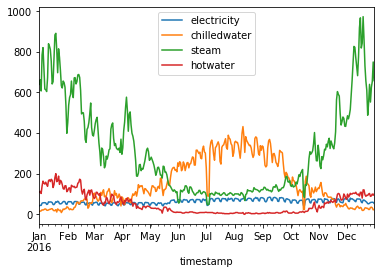

In [4]:
train_df[train_df.meter==0].resample('D').median().meter_reading.plot(label = 'electricity')
train_df[train_df.meter==1].resample('D').median().meter_reading.plot(label = 'chilledwater')
train_df[train_df.meter==2].resample('D').median().meter_reading.plot(label = 'steam')
train_df[train_df.meter==3].resample('D').median().meter_reading.plot(label = 'hotwater')
plt.legend()

# 檢視資料分布
- 資料分布偏態太大，特徵工程需要注意
    1. 對數去偏 np.log1p

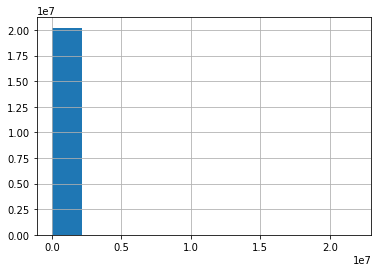

In [7]:
train_df.meter_reading.hist()

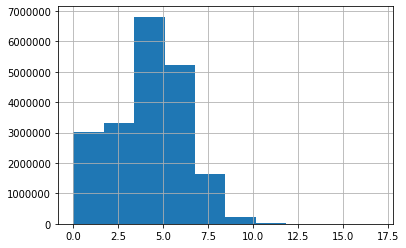

In [8]:
np.log1p(train_df.meter_reading).hist()

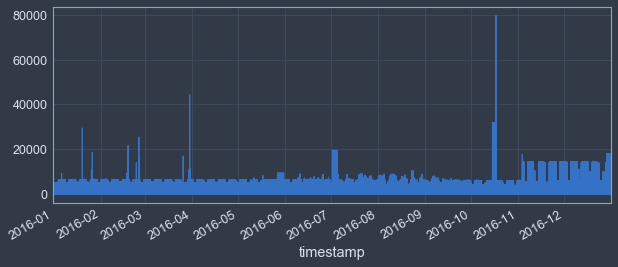

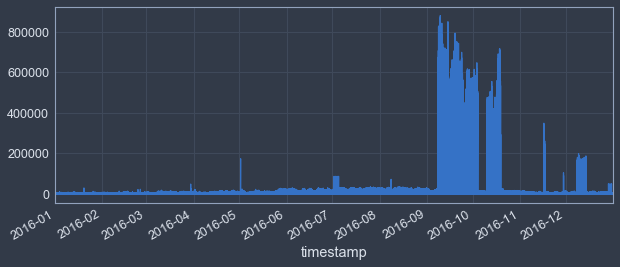

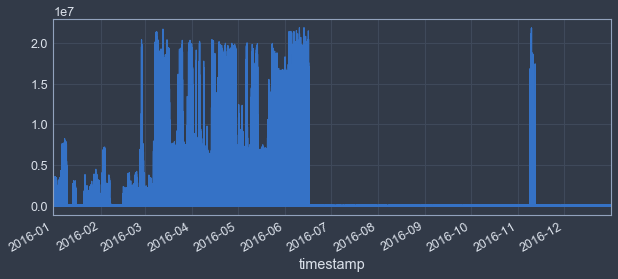

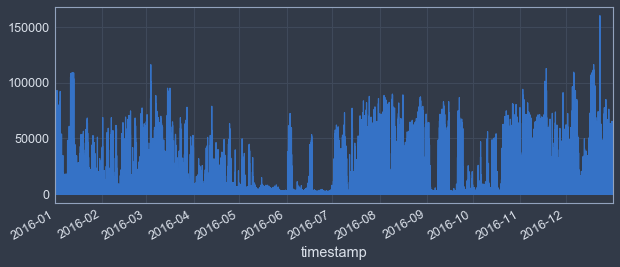

In [47]:
# for each type of meter, plot the raw data to ensure the stability of meter 
for i in range(4):
    train_df[train_df.meter==i].meter_reading.plot(figsize=(10,4))
    plt.show()

## 刪除異常值  
在討論區有人提到 5/20號前 side_id =0 的基本上都是0(或是極小)，感覺是記數或是Sensor單位/採樣等等  
的方式換了，所以先將異常值去除掉，不然整體訓練出來的情況會很奇怪
> 註記：基本上EDA就是要善用各種視覺化技術探勘資料，才有可能發現這樣的異常情況，這些異常值對模型的殺傷力會非常的大...

# Removing weired data on site_id 0 
- As you can see above, this data looks weired until May 20. It is reported in this discussion by @barnwellguy that All electricity meter is 0 until May 20 for site_id == 0. I will remove these data from training data.
- It corresponds to building_id <= 104.
- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113054#656588

In [10]:
def plot_date_usage(train_df, meter=0, building_id=0):
    train_temp_df = train_df[train_df['meter'] == meter]
    train_temp_df = train_temp_df[train_temp_df['building_id'] == building_id]
    train_temp_df = train_temp_df.resample('D').mean()
    train_temp_df.meter_reading.plot(label = building_id)
    
    #return train_temp_df

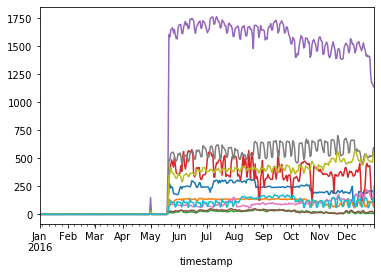

In [12]:
for i in range(10):
    plot_date_usage(train_df, meter=0, building_id=i)


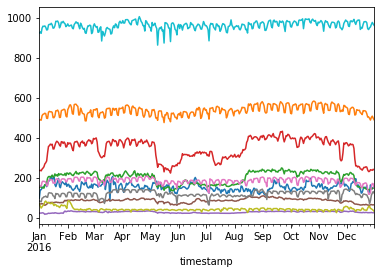

In [13]:
for i in range(200,210):
    plot_date_usage(train_df, meter=0, building_id=i)

# Chapter 2 特徵工程 Feature Engineering
- 建立同一PipeLine讓之後的測試集一起處理
- 基本上會先對上一章提到EDA發現的異常先做處理(直接去掉，還沒發現更好的方法)
- 時間編碼  
  時間編碼分成假日編碼, 是否是六日, 和一天中的時段, 還有建築老化程度  
  基本上大概的想法就是分成working和holiday
- 特徵選取
  (待補充)

In [8]:
def DataProcessPipeLine(train_df,building_df,weather_df,test=False):
    
    #確保時間格式
    train_df.timestamp = pd.to_datetime(train_df.timestamp)
    weather_df.timestamp = pd.to_datetime(weather_df.timestamp)
    
    #去除異常的數值
    train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')
    merged = train_df.merge(building_df,on="building_id", how="left")
    merged = merged.merge(weather_df, on=["site_id", "timestamp"], how="left")
    
    if not test:
        #按照時間排序哦!
        merged.sort_values("timestamp", inplace=True)
        merged.reset_index(drop=True, inplace=True)
    
    #特徵工程
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
    
    merged["hour"] =        merged.timestamp.dt.hour
    merged["weekday"] =     merged.timestamp.dt.weekday
    merged["is_holiday"] = (merged.timestamp.dt.date.astype("str").isin(holidays)).astype(int)
    merged['year_built'] = 2018 - merged['year_built']
    
    #溫度就能代表這些特徵，不需要太多一樣無意義的特徵
    drop_features = ["timestamp", "sea_level_pressure", "wind_direction", "wind_speed"]
    merged.drop(drop_features, axis=1, inplace=True)
    
    if test:
        row_ids = merged.row_id
        merged.drop("row_id", axis=1, inplace=True)
        return merged, row_ids
    else:
        y = np.log1p(merged['meter_reading'])
        X = merged.drop("meter_reading", axis=1)
    
    return X,y
    

In [9]:
X_train, y_train = DataProcessPipeLine(train_df, building_df, weather_train_df)


## 模型介紹 LightGBM
- 本次競賽是第一次應用LightGBM,之前都是用xgboost
- XGBoost是levelwise對每一層葉子分割都一樣, LightGBM則是leaf-wise, 找出最大增益分割點
- 雖然leaf-wise可能會overfitting, 但是可以限制max-depth
- 使用Histogram的概念將連續值"離散化" 

# 模型想法: HALF-HALF
- 將訓練集拆成A,B兩份
- 

In [30]:
import lightgbm as lgb
X_half_1 = X_train[:int(X_train.shape[0] / 2)]
X_half_2 = X_train[int(X_train.shape[0] / 2):]

y_half_1 = y_train[:int(X_train.shape[0] / 2)]
y_half_2 = y_train[int(X_train.shape[0] / 2):]

categorical_features = ["building_id", "site_id", "meter", "primary_use", "hour", "weekday"]

d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

watchlist_1 = [d_half_1, d_half_2]
watchlist_2 = [d_half_2, d_half_1]

params = {
    "objective": "regression",
    "boosting": "gbdt", #梯度提升樹效果最好
    "num_leaves": 40, 
    "learning_rate": 0.05,
    "feature_fraction": 0.85, #每次分裂前從前面選取85%特徵
    "reg_lambda": 2,
    "metric": "rmse"
}

print("Building model with first half and validating on second half:")
model_half_1 = lgb.train(params, train_set=d_half_1, num_boost_round=1000, valid_sets=watchlist_1, verbose_eval=200, early_stopping_rounds=200)

print("Building model with second half and validating on first half:")
model_half_2 = lgb.train(params, train_set=d_half_2, num_boost_round=1000, valid_sets=watchlist_2, verbose_eval=200, early_stopping_rounds=200)

Building model with first half and validating on second half:


C:\Users\ddx00\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.881636	valid_1's rmse: 1.14628
[400]	training's rmse: 0.833633	valid_1's rmse: 1.13892
[600]	training's rmse: 0.814754	valid_1's rmse: 1.13873
Early stopping, best iteration is:
[503]	training's rmse: 0.823613	valid_1's rmse: 1.13796
Building model with second half and validating on first half:
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.902224	valid_1's rmse: 1.15518
[400]	training's rmse: 0.851103	valid_1's rmse: 1.14648
[600]	training's rmse: 0.831752	valid_1's rmse: 1.14477
[800]	training's rmse: 0.81652	valid_1's rmse: 1.14547
Early stopping, best iteration is:
[640]	training's rmse: 0.829568	valid_1's rmse: 1.14419


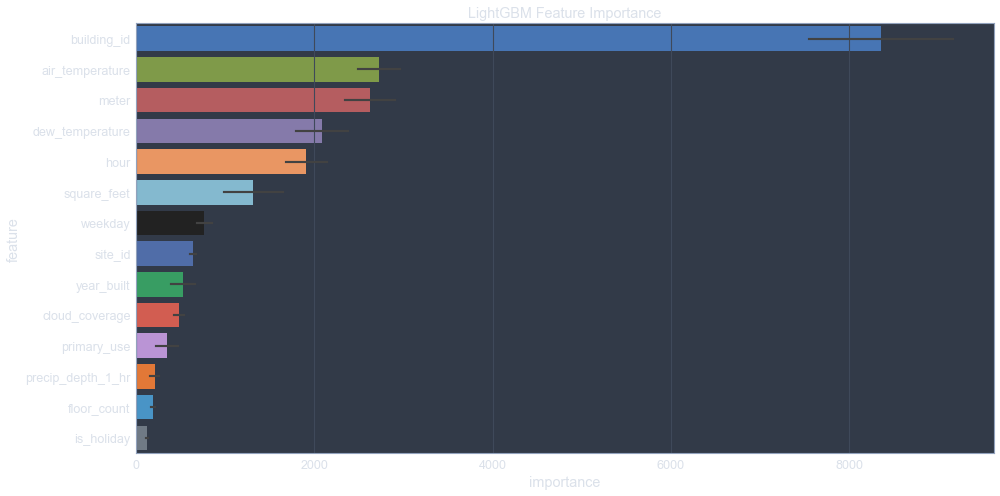

In [31]:
df_fimp_1 = pd.DataFrame()
df_fimp_1["feature"] = X_train.columns.values
df_fimp_1["importance"] = model_half_1.feature_importance()
df_fimp_1["half"] = 1

df_fimp_2 = pd.DataFrame()
df_fimp_2["feature"] = X_train.columns.values
df_fimp_2["importance"] = model_half_2.feature_importance()
df_fimp_2["half"] = 2

df_fimp = pd.concat([df_fimp_1, df_fimp_2], axis=0)

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

In [41]:
X_test, row_ids = DataProcessPipeLine(test_df, building_df, weather_test_df, test=True)

In [42]:
pred = np.expm1(model_half_1.predict(X_test, num_iteration=model_half_1.best_iteration)) / 2
pred += np.expm1(model_half_2.predict(X_test, num_iteration=model_half_2.best_iteration)) / 2
    

In [43]:
submission = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(pred, 0, a_max=None)})
submission.to_csv("submission.csv", index=False)

In [ ]:
submission